 ## Table Of Contents
 1. [Caricamento dei dati](#load)<br>
     1.1 [Grafici di esempio](#esempi)
 2. [Calcolo delle variabili di riassunto](#variabili)
 3. [Split train-validation-test](#tvt)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Funzioni base:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
# from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten,ScatterGroup, MatriceConfusione, indice_gini
from funzioni import tasso_errata_classificazione, grafico_metrica_iperparametro, grafico_metrica_iperparametri
from funzioni.grafici import grafico_importanza_variabili

# 1. Caricamento dei dati <a id=load> </a>

In [3]:
PATH_DATA = './PhonePi/data/'
FIG_PATH = './figure/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [4]:
p = 150 # numero osservazioni per intervallo
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(p)])
nomi_colonna
X=pd.DataFrame(columns=nomi_colonna)

for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-p, p)] # intervalli di dt*100ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*p:(j+1)*p])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:08<00:00,  6.25it/s]


## 1.1 Grafici di esempio <a id=esempi> </a>

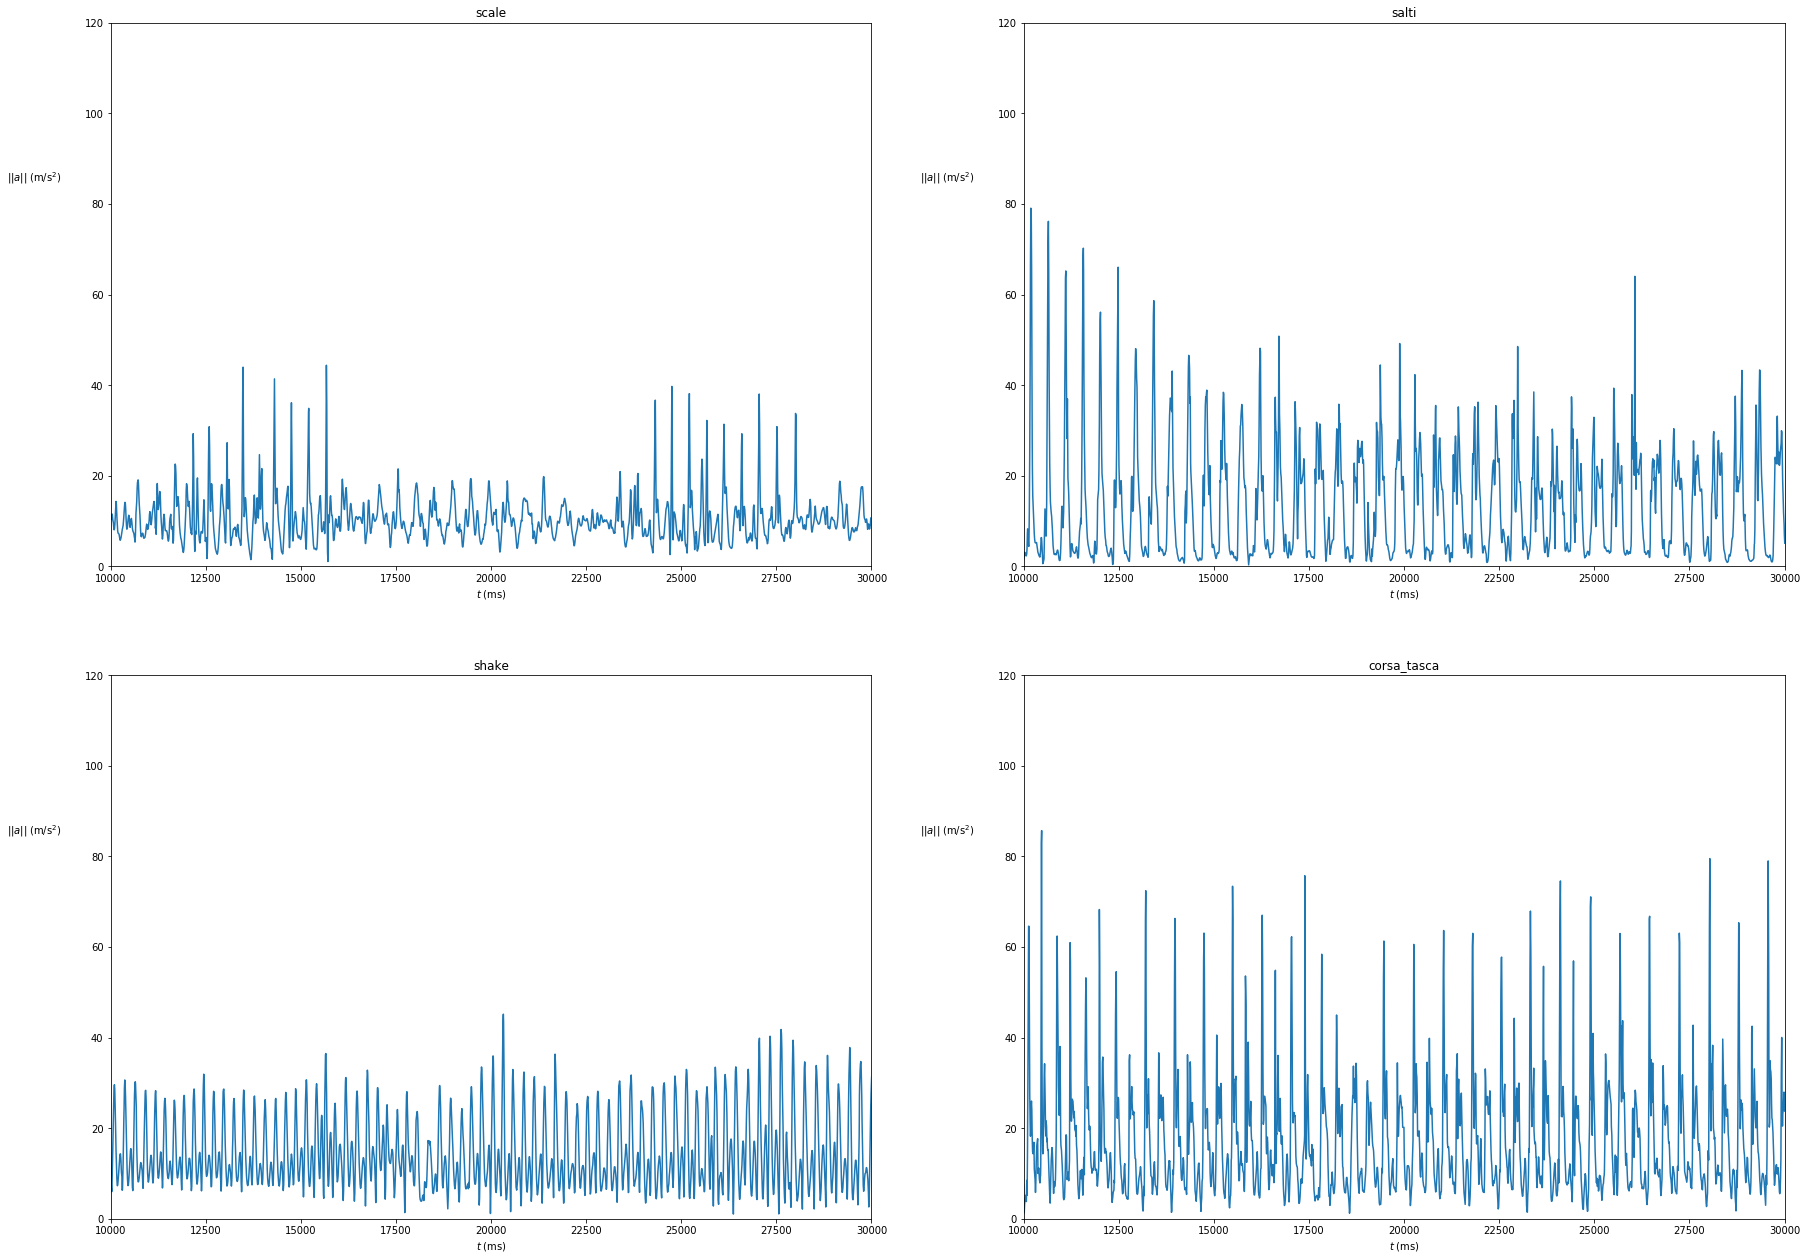

In [5]:
DIRM = ['./PhonePi/data/scale-martina',
        './PhonePi/data/salti-daniele',
        './PhonePi/data/shake-anna',
        './PhonePi/data/corsa_tasca-alberto'
       ]
loc = [1,2,3,4]
plt.figure(figsize=(7.5*len(DIRM),5.5*len(DIRM)))
for i in range(4):
    data = pd.read_csv(DIRM[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    ax = plt.subplot(2, 2, i+1 , ylim=(0,120), xlim = (10000,30000))
    ax.set_ylabel(r"$\|\|a\|\|\;(\mathrm{ m/s}^2)$", rotation=0)
    ax.yaxis.set_label_coords(-0.1,0.7)
    ax.set_xlabel(r"$t \;(\mathrm{ ms})$")
    ax.set_title((DIRM[i].split("/")[-1]).split("-")[0])
    plt.plot(data["t"],data["a"])
    plt.savefig(FIG_PATH+"espl.png", dpi=150)
plt.show()

# 2. Calcolo delle variabili di riassunto <a id=variabili> </a>

In [6]:
y = X.azione
X.drop("azione", axis=1, inplace=True)
Xnum = X.drop("user", axis=1)

In [7]:
maxA = Xnum.max(1) # massimo accelerazione
MVDeriv = AbsMeanVarDeriv(Xnum, 10) # variazione media della derivata
meanA = Xnum.mean(axis=1)
varA = Xnum.var(axis=1)
medA = Xnum.median(axis=1)
minA = Xnum.min(axis=1)

In [8]:
espl = pd.concat([maxA, MVDeriv, meanA, varA, medA, minA], axis=1)
espl.columns=["maxA", "MVDeriv", "meanA", "varA", "medA", "minA"]

In [9]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")
espl.to_pickle("espl.pkl")

In [10]:
#per luisa
X.to_csv("X-2s.csv")
y.to_csv("y-2s.csv")
espl.to_csv("espl.csv")

# 3.  Split train-validation-test <a id="tvt"> </a>

In [11]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.3, random_state=42, )

In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
y_test.to_pickle("y_test.pkl")
X_test.to_pickle("X_test.pkl")

In [13]:
X_train.to_pickle("X_train.pkl")
X_val.to_pickle("X_val.pkl")
y_train.to_pickle("y_train.pkl")
y_val.to_pickle("y_val.pkl")